### NOT: 
Bu hafta yapmış olduğum çalışma, bir önceki hafta yapmış olduğum "Lineer Regresyon ile Hitters Salary Prediction" çalışmasının güncellenmiş halidir. Buna göre, farklı makine öğrenmesi modelleri ve hiperparametre optimizasyonu ile hata kriteri olarak değerlendirilen RMSE değeri 150'nin altına indirilmiştir.

# 1- Exploratory Data Analysis (Keşifçi Veri Analizi)

## 1.1-Veri Setini İnceleme

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import missingno as msno
from datetime import date
from sklearn.metrics import accuracy_score
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,roc_auc_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.linear_model import LinearRegression
from dython import nominal
from dython.data_utils import split_hist
from IPython.core.display import HTML
from scipy.stats import norm
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

import warnings
warnings.simplefilter(action='ignore', category=Warning)

C:\Users\eyp_d\anaconda3\lib\site-packages\dask\dataframe\utils.py:369: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
C:\Users\eyp_d\anaconda3\lib\site-packages\dask\dataframe\utils.py:369: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
C:\Users\eyp_d\anaconda3\lib\site-packages\dask\dataframe\utils.py:369: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
C:\Users\eyp_d\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is

In [2]:
pd.set_option("display.max_columns", 8)
pd.set_option("display.max_rows", None)
pd.set_option("display.float_format", lambda x: "%.3f" % x)
pd.set_option("display.width", 500)

In [3]:
def load_hitters():
    df = pd.read_csv("C:/Users/eyp_d/Desktop/VBO-Bootcamp-Dersler/7.Hafta/Ders Öncesi Notlar/datasets/hitters.csv")
    return df

In [4]:
df = load_hitters()
df.head()

,AtBat,Hits,HmRun,Runs,...,Assists,Errors,Salary,NewLeague
0,293,66,1,30,...,33,20,NaN,A
1,315,81,7,24,...,43,10,475.000,N
2,479,130,18,66,...,82,14,480.000,A
3,496,141,20,65,...,11,3,500.000,N
4,321,87,10,39,...,40,4,91.500,N


In [5]:
df.shape  # Veri seti boyutu 

(322, 20)

In [6]:
df.describe() # Veri seti değişkenlerine ait özet istatistik bilgisi

,AtBat,Hits,HmRun,Runs,...,PutOuts,Assists,Errors,Salary
count,322.000,322.000,322.000,322.000,...,322.000,322.000,322.000,263.000
mean,380.929,101.025,10.770,50.910,...,288.938,106.913,8.040,535.926
std,153.405,46.455,8.709,26.024,...,280.705,136.855,6.368,451.119
min,16.000,1.000,0.000,0.000,...,0.000,0.000,0.000,67.500
25%,255.250,64.000,4.000,30.250,...,109.250,7.000,3.000,190.000
50%,379.500,96.000,8.000,48.000,...,212.000,39.500,6.000,425.000
75%,512.000,137.000,16.000,69.000,...,325.000,166.000,11.000,750.000
max,687.000,238.000,40.000,130.000,...,1378.000,492.000,32.000,2460.000


CatBat, CWalks, PutOuts gibi değişkenlerde outlier(aykırı değer) olabilir.

In [7]:
df.columns = [col.upper() for col in df.columns]
df.head(2)

,ATBAT,HITS,HMRUN,RUNS,...,ASSISTS,ERRORS,SALARY,NEWLEAGUE
0,293,66,1,30,...,33,20,NaN,A
1,315,81,7,24,...,43,10,475.000,N


Değişken adları kullanım kolaylığı için büyük harflere çevirildi.

## 1.2-Değişkenler Arasındaki Korelasyon Analizi

Tüm değişkenlerin birbiri arasındaki korelasyonunu incelemek için ana dataframe'i üzerinde değişiklik yapmadan Label(Binary) Encoding işlemi yapılacaktır.

In [8]:
# Korelasyon grafiği için kullandığım aşağıdaki kod parçası bana ait değildir.
# Korelasyon grafiği kaynak kodları için: https://www.kaggle.com/drazen/heatmap-with-sized-markers

from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np


def heatmap(x, y, **kwargs):
    if 'color' in kwargs:
        color = kwargs['color']
    else:
        color = [1]*len(x)

    if 'palette' in kwargs:
        palette = kwargs['palette']
        n_colors = len(palette)
    else:
        n_colors = 256 # Use 256 colors for the diverging color palette
        palette = sns.color_palette("Blues", n_colors) 

    if 'color_range' in kwargs:
        color_min, color_max = kwargs['color_range']
    else:
        color_min, color_max = min(color), max(color) # Range of values that will be mapped to the palette, i.e. min and max possible correlation

    def value_to_color(val):
        if color_min == color_max:
            return palette[-1]
        else:
            val_position = float((val - color_min)) / (color_max - color_min) # position of value in the input range, relative to the length of the input range
            val_position = min(max(val_position, 0), 1) # bound the position betwen 0 and 1
            ind = int(val_position * (n_colors - 1)) # target index in the color palette
            return palette[ind]

    if 'size' in kwargs:
        size = kwargs['size']
    else:
        size = [1]*len(x)

    if 'size_range' in kwargs:
        size_min, size_max = kwargs['size_range'][0], kwargs['size_range'][1]
    else:
        size_min, size_max = min(size), max(size)

    size_scale = kwargs.get('size_scale', 500)

    def value_to_size(val):
        if size_min == size_max:
            return 1 * size_scale
        else:
            val_position = (val - size_min) * 0.99 / (size_max - size_min) + 0.01 # position of value in the input range, relative to the length of the input range
            val_position = min(max(val_position, 0), 1) # bound the position betwen 0 and 1
            return val_position * size_scale
    if 'x_order' in kwargs: 
        x_names = [t for t in kwargs['x_order']]
    else:
        x_names = [t for t in sorted(set([v for v in x]))]
    x_to_num = {p[1]:p[0] for p in enumerate(x_names)}

    if 'y_order' in kwargs: 
        y_names = [t for t in kwargs['y_order']]
    else:
        y_names = [t for t in sorted(set([v for v in y]))]
    y_to_num = {p[1]:p[0] for p in enumerate(y_names)}

    plot_grid = plt.GridSpec(1, 15, hspace=0.2, wspace=0.1) # Setup a 1x10 grid
    ax = plt.subplot(plot_grid[:,:-1]) # Use the left 14/15ths of the grid for the main plot

    marker = kwargs.get('marker', 's')

    kwargs_pass_on = {k:v for k,v in kwargs.items() if k not in [
         'color', 'palette', 'color_range', 'size', 'size_range', 'size_scale', 'marker', 'x_order', 'y_order'
    ]}

    ax.scatter(
        x=[x_to_num[v] for v in x],
        y=[y_to_num[v] for v in y],
        marker=marker,
        s=[value_to_size(v) for v in size], 
        c=[value_to_color(v) for v in color],
        **kwargs_pass_on
    )
    ax.set_xticks([v for k,v in x_to_num.items()])
    ax.set_xticklabels([k for k in x_to_num], rotation=45, horizontalalignment='right')
    ax.set_yticks([v for k,v in y_to_num.items()])
    ax.set_yticklabels([k for k in y_to_num])

    ax.grid(False, 'major')
    ax.grid(True, 'minor')
    ax.set_xticks([t + 0.5 for t in ax.get_xticks()], minor=True)
    ax.set_yticks([t + 0.5 for t in ax.get_yticks()], minor=True)

    ax.set_xlim([-0.5, max([v for v in x_to_num.values()]) + 0.5])
    ax.set_ylim([-0.5, max([v for v in y_to_num.values()]) + 0.5])
    ax.set_facecolor('#F1F1F1')

    # Add color legend on the right side of the plot
    if color_min < color_max:
        ax = plt.subplot(plot_grid[:,-1]) # Use the rightmost column of the plot

        col_x = [0]*len(palette) # Fixed x coordinate for the bars
        bar_y=np.linspace(color_min, color_max, n_colors) # y coordinates for each of the n_colors bars

        bar_height = bar_y[1] - bar_y[0]
        ax.barh(
            y=bar_y,
            width=[5]*len(palette), # Make bars 5 units wide
            left=col_x, # Make bars start at 0
            height=bar_height,
            color=palette,
            linewidth=0
        )
        ax.set_xlim(1, 2) # Bars are going from 0 to 5, so lets crop the plot somewhere in the middle
        ax.grid(False) # Hide grid
        ax.set_facecolor('white') # Make background white
        ax.set_xticks([]) # Remove horizontal ticks
        ax.set_yticks(np.linspace(min(bar_y), max(bar_y), 3)) # Show vertical ticks for min, middle and max
        ax.yaxis.tick_right() # Show vertical ticks on the right 


def corrplot(data, size_scale=500, marker='s'):
    corr = pd.melt(data.reset_index(), id_vars='index')
    corr.columns = ['x', 'y', 'value']
    heatmap(
        corr['x'], corr['y'],
        color=corr['value'], color_range=[-1, 1],
        palette=sns.diverging_palette(20, 220, n=256),
        size=corr['value'].abs(), size_range=[0,1],
        marker=marker,
        x_order=data.columns,
        y_order=data.columns[::-1],
        size_scale=size_scale
    )

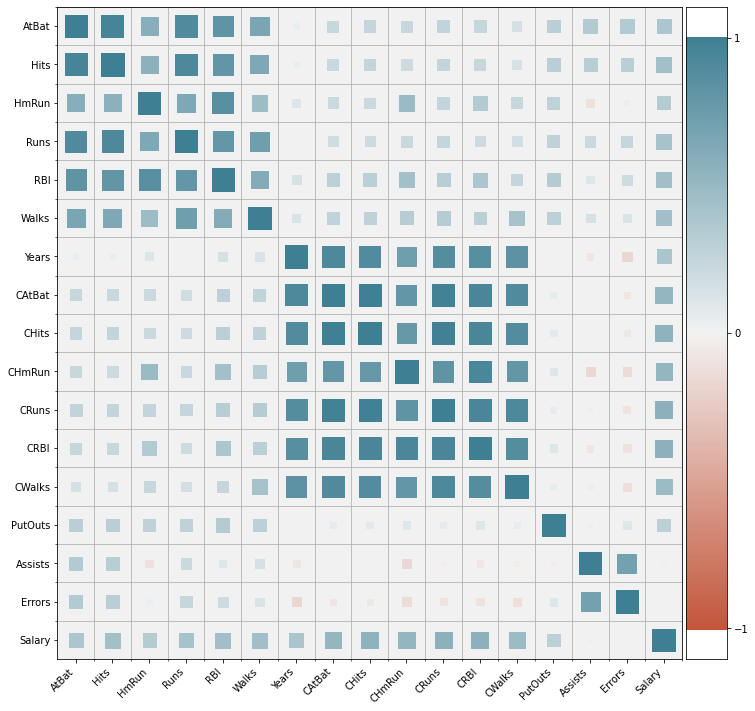

In [9]:
corr_df = load_hitters()  # Korelasyon grafiği kaynak kodları için: https://www.kaggle.com/drazen/heatmap-with-sized-markers
corr = corr_df.corr()
plt.figure(figsize=(12, 12))
corrplot(corr)

Görüldüğü üzere bağımlı değişken(SALARY) ile en yüksek korelasyona sahip değişkenler: HITS, RBI, WALKS, CRUNS, RUNS ... olarak sıralanabilir.

## 1.3-Numerik ve Kategorik Değişkenlerin Analizi

grab_col_names() fonksiyonu bir dataframedeki değişkenlerin türlerini göstermek için kullanılır.

In [10]:
def grab_col_names(dataframe, cat_th=10, car_th=20):

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]
  
    return cat_cols, num_cols, cat_but_car

In [11]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

### 1.3.1-Kategorik Değişkenlerin Bağımlı Değişkene Göre Analizi

Veri setindeki değişkenlerin bağımlı değişkenle olan korelasyon grafiği incelenerek, yüksek korelasyon değerlerine sahip kategorik değişkenler bu bölümde incelenecektir.

cat_summary() veri setindeki kategorik değişkenlerin dağılımını veren özet fonksiyonudur.

In [12]:
def cat_summary(dataframe, col_name, target_col):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe),
                        f"{target_col}"+"_Mean": df.groupby(col_name)[target_col].mean()}))

cat_distribution_plot() veri setindeki kategorik değişkenlerin bağımlı değişkene göre dağılımını gösteren grafik fonksiyonudur.

In [13]:
def cat_distribution_plot(df, cat_col, target_col):
    split_hist(df, target_col, split_by=cat_col, ylabel="Gözlem Sayısı", 
               title=f"{target_col}'e göre {cat_col} Dağılımı", bins=25, figsize=(12.1,4))
    plt.show()

cat_analyser_plot() veri setindeki kategorik değişkenlerin dağılımı ve bağımlı değişkenle olan ilişkisini gösteren grafik fonksiyonudur.

In [14]:
def cat_analyser_plot(df, cat_col, target_col): 
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    df[cat_col].value_counts().plot(kind='bar', ax=axes[0], color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
    axes[0].set_title(f"{cat_col} Dağılımı")
    axes[0].set_xlabel(f"{cat_col}")
    axes[0].set_ylabel("Gözlem Sayısı")
    
    df.groupby(cat_col)[target_col].mean().plot(kind='bar', ax=axes[1], color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'] )
    axes[1].set_title(f"{cat_col}"+" "+"Kırılımında"+" "+f"{target_col}"+" "+ "Ortalaması")
    axes[1].set_xlabel(f"{cat_col}")
    axes[1].set_ylabel(f"{target_col}")
    plt.xticks(rotation=0)
    plt.show()
    
    cat_distribution_plot(df, cat_col, target_col)    

In [15]:
cat_summary(df, "LEAGUE", "SALARY")

   LEAGUE  Ratio  SALARY_Mean
A     175 54.348      542.000
N     147 45.652      529.118


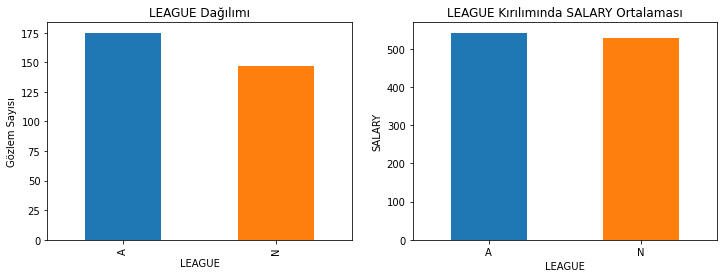

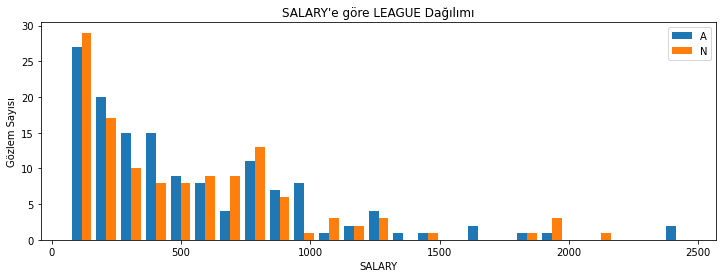

In [16]:
cat_analyser_plot(df, "LEAGUE", "SALARY")

Yukarıdaki grafiklerden anlaşılacağı üzere, N liginde oynayan oyuncular A liginde oynayanlara göre daha az olmasına karşın SALARY ortalamasında yaklaşık olarak benzer sonuç göstermişler. Buna göre, bir oyuncu için N liginde oynamanın daha fazla maaş(SALARY) getirdiği yorumu yapılabilir.

In [17]:
cat_summary(df, "DIVISION", "SALARY")

   DIVISION  Ratio  SALARY_Mean
E       157 48.758      624.271
W       165 51.242      450.877


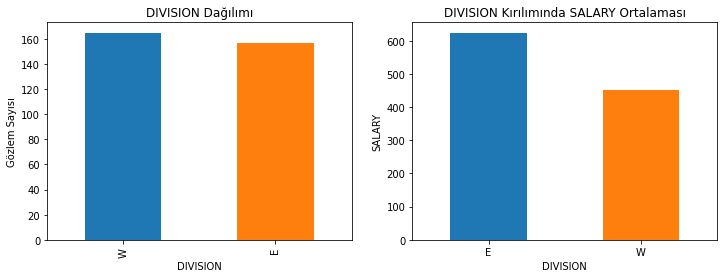

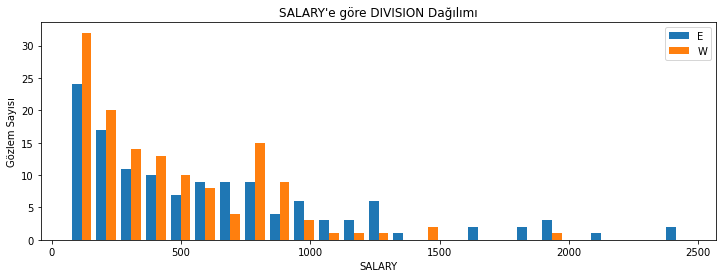

In [18]:
cat_analyser_plot(df, "DIVISION", "SALARY")

Oyuncuların oyun sahasındaki pozisyonların dağılımı neredeyse aynı sonuç gösterse de E pozisyonunda oynayan oyuncuların maaş(SALARY) ortalaması daha yüksek. Bu sebep, oyuncuya ait SALARY değişkeni oynadığı pozisyona göre değişmekte ve E pozisyonu için pozitif yönlüdür. 

In [19]:
cat_summary(df, "NEWLEAGUE", "SALARY")

   NEWLEAGUE  Ratio  SALARY_Mean
A        176 54.658      537.113
N        146 45.342      534.554


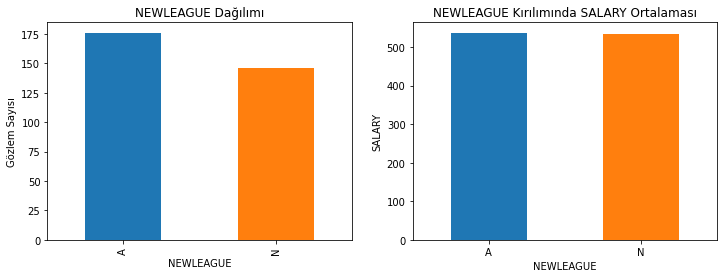

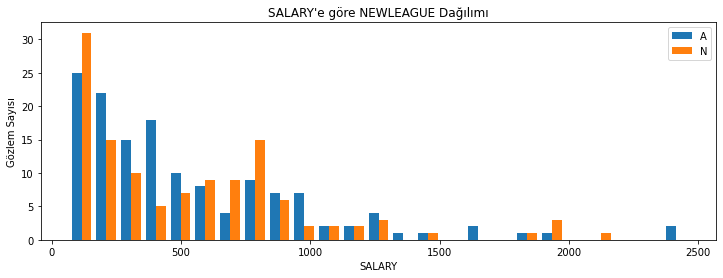

In [20]:
cat_analyser_plot(df, "NEWLEAGUE", "SALARY")

NEWLEAGUE değişkeninin dağılımı da beklenildiği üzere LEAGUE değişken dağılımına benzemektedir. Aynı yorumlar bu değişken için de yapılabilir.

### 1.3.2-Nümerik Değişkenlerin Bağımlı Değişkene Göre Analizi

Veri setindeki değişkenlerin bağımlı değişkenle olan korelasyon grafiği incelenerek, yüksek korelasyon değerlerine sahip nümerik değişkenler bu bölümde incelenecektir.

In [21]:
num_cols  # Nümerik değişkenler

['ATBAT',
 'HITS',
 'HMRUN',
 'RUNS',
 'RBI',
 'WALKS',
 'YEARS',
 'CATBAT',
 'CHITS',
 'CHMRUN',
 'CRUNS',
 'CRBI',
 'CWALKS',
 'PUTOUTS',
 'ASSISTS',
 'ERRORS',
 'SALARY']

num_summary() veri setindeki nümerik değişkenlerin dağılımını veren özet fonksiyonudur.

In [22]:
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print("\t\t\t"+f"{numerical_col}"+" Nümerik Değişken Özet İstatistiği")
    print("\t\t\t---------------------------------------------")
    print(pd.DataFrame(dataframe[numerical_col].describe(quantiles)).T, "\n")

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show()

num_analyser_plot() veri setindeki nümerik değişkenlerin dağılımı ve bağımlı değişkenle olan ilişkisini gösteren grafik fonksiyonudur.

In [23]:
def num_analyser_plot(df, num_col, target_col):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    sns.histplot(df[num_col], kde=True, bins=30, ax=axes[0]);
    axes[0].lines[0].set_color('green')
    axes[0].set_title(f"{num_col}"+" "+"Dağılımı")
    axes[0].set_ylabel("Gözlem Sayısı")
    
    quantiles = [0, 0.25, 0.50, 0.75, 1]
    num_df = df.copy()
    num_df[f"{num_col}"+"_CAT"] = pd.qcut(df[num_col], q=quantiles) # nümerik değişken kategorize edildi.
    df_2 = num_df.groupby(f"{num_col}"+"_CAT")[target_col].mean()
    
    sns.barplot(x=df_2.index, y=df_2.values);
    axes[1].set_title(f"{num_col} Kırılımında {target_col} Ortalaması")
    axes[1].set_ylabel(f"{target_col}")

    plt.show()

			HITS Nümerik Değişken Özet İstatistiği
			---------------------------------------------
       count    mean    std   min  ...     90%     95%     99%     max
HITS 322.000 101.025 46.455 1.000  ... 163.000 174.000 210.790 238.000

[1 rows x 17 columns] 



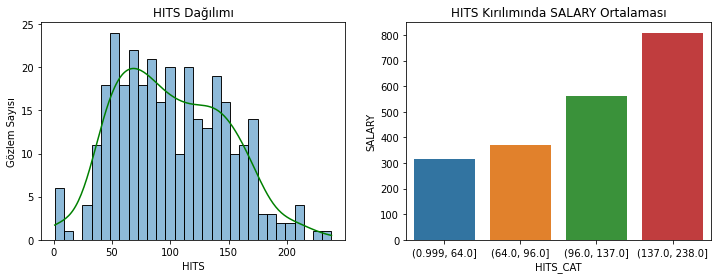

In [24]:
num_summary(df, "HITS")
num_analyser_plot(df, "HITS", "SALARY")

Yukarıdaki grafiğe göre, bir oyuncu için HITS(1986-1987 sezonundaki isabet sayısı) arttıkça ortalama SALARY değeri artmaktadır.

			RBI Nümerik Değişken Özet İstatistiği
			---------------------------------------------
      count   mean    std   min  ...    90%    95%     99%     max
RBI 322.000 48.028 26.167 0.000  ... 86.000 96.000 112.370 121.000

[1 rows x 17 columns] 



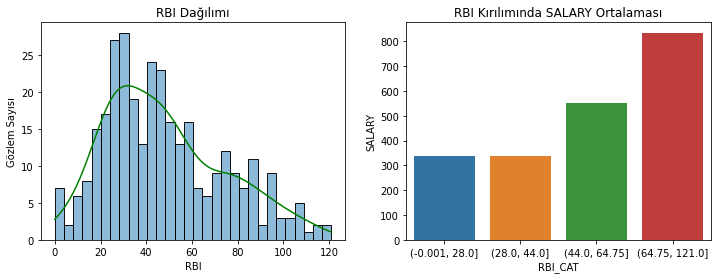

In [25]:
num_summary(df, "RBI")
num_analyser_plot(df, "RBI", "SALARY")

Yukarıdaki grafiğe göre, bir oyuncu için RBI (Bir vurucunun vuruş yaptıgında koşu yaptırdığı oyuncu sayısı) arttıkça ortalama SALARY değeri artmaktadır.

			WALKS Nümerik Değişken Özet İstatistiği
			---------------------------------------------
        count   mean    std   min  ...    90%    95%    99%     max
WALKS 322.000 38.742 21.639 0.000  ... 69.900 78.000 93.580 105.000

[1 rows x 17 columns] 



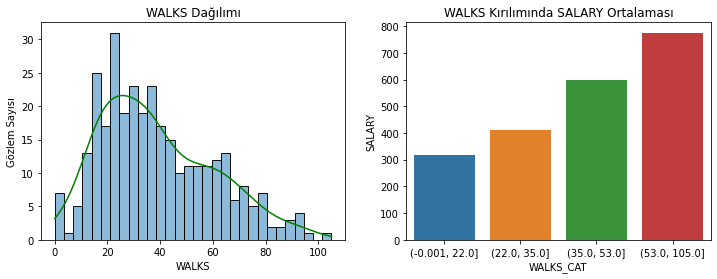

In [26]:
num_summary(df, "WALKS")
num_analyser_plot(df, "WALKS", "SALARY")

Yukarıdaki grafiğe göre, bir oyuncu için WALKS (karşı oyuncuya yaptırılan hata sayısı) arttıkça ortalama SALARY değeri artmaktadır.

			CRUNS Nümerik Değişken Özet İstatistiği
			---------------------------------------------
        count    mean     std   min  ...     90%      95%      99%      max
CRUNS 322.000 358.795 334.106 1.000  ... 895.700 1032.300 1174.370 2165.000

[1 rows x 17 columns] 



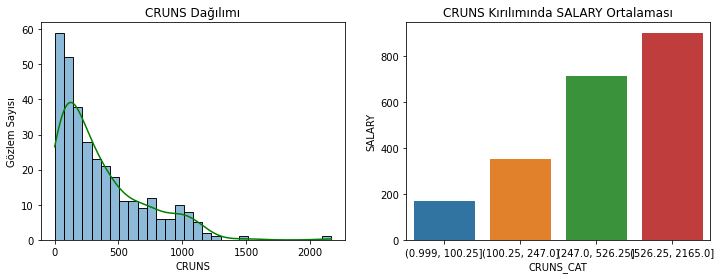

In [27]:
num_summary(df, "CRUNS")
num_analyser_plot(df, "CRUNS", "SALARY")

Ykarıdaki grafiklerden, CRUNS(Oyuncunun kariyeri boyunca takımına kazandırdığı sayı) değişkeninin veri seti üzerinde 0-150 değerleri arasında kaldığı ve bu sebeple SALARY değişkenine doğrudan pozitif yönlü etki ettiğini görmek mümkün. 

## 1.4-Aykırı Gözlem Analizi

Bu bölümde veri seti değişkenlerine ait verilerdeki aykırı gözlemler tespit edilecektir.

outliers_boxplot() Veri setindeki nümerik değişkenlerdeki aykırı gözlemleri gösteren grafik fonksiyonudur.

In [28]:
def outliers_boxplot(dataframe, num_cols):
    plt.figure(figsize=(12,6),dpi=200)
    plt.title("Numerik Değişkenlerin Boxplot ile Ayrkırı Gözlem Analizi")
    sns.set_theme(style="whitegrid")
    sns.boxplot(data=df.loc[:, num_cols], orient="h", palette="Set3") 
    plt.show()    

Outlier bulunduran değişkenler çok olduğundan grafik üzerinde net incelenebilmesi adına ikiye ayrılmıştır.

In [29]:
df_mean = int(df.mean(numeric_only=True).quantile(0.5))
high_cols = []
low_cols = []
for col in num_cols:
    if df[col].mean() >= df_mean:
        high_cols.append(col)
    else:
        low_cols.append(col)

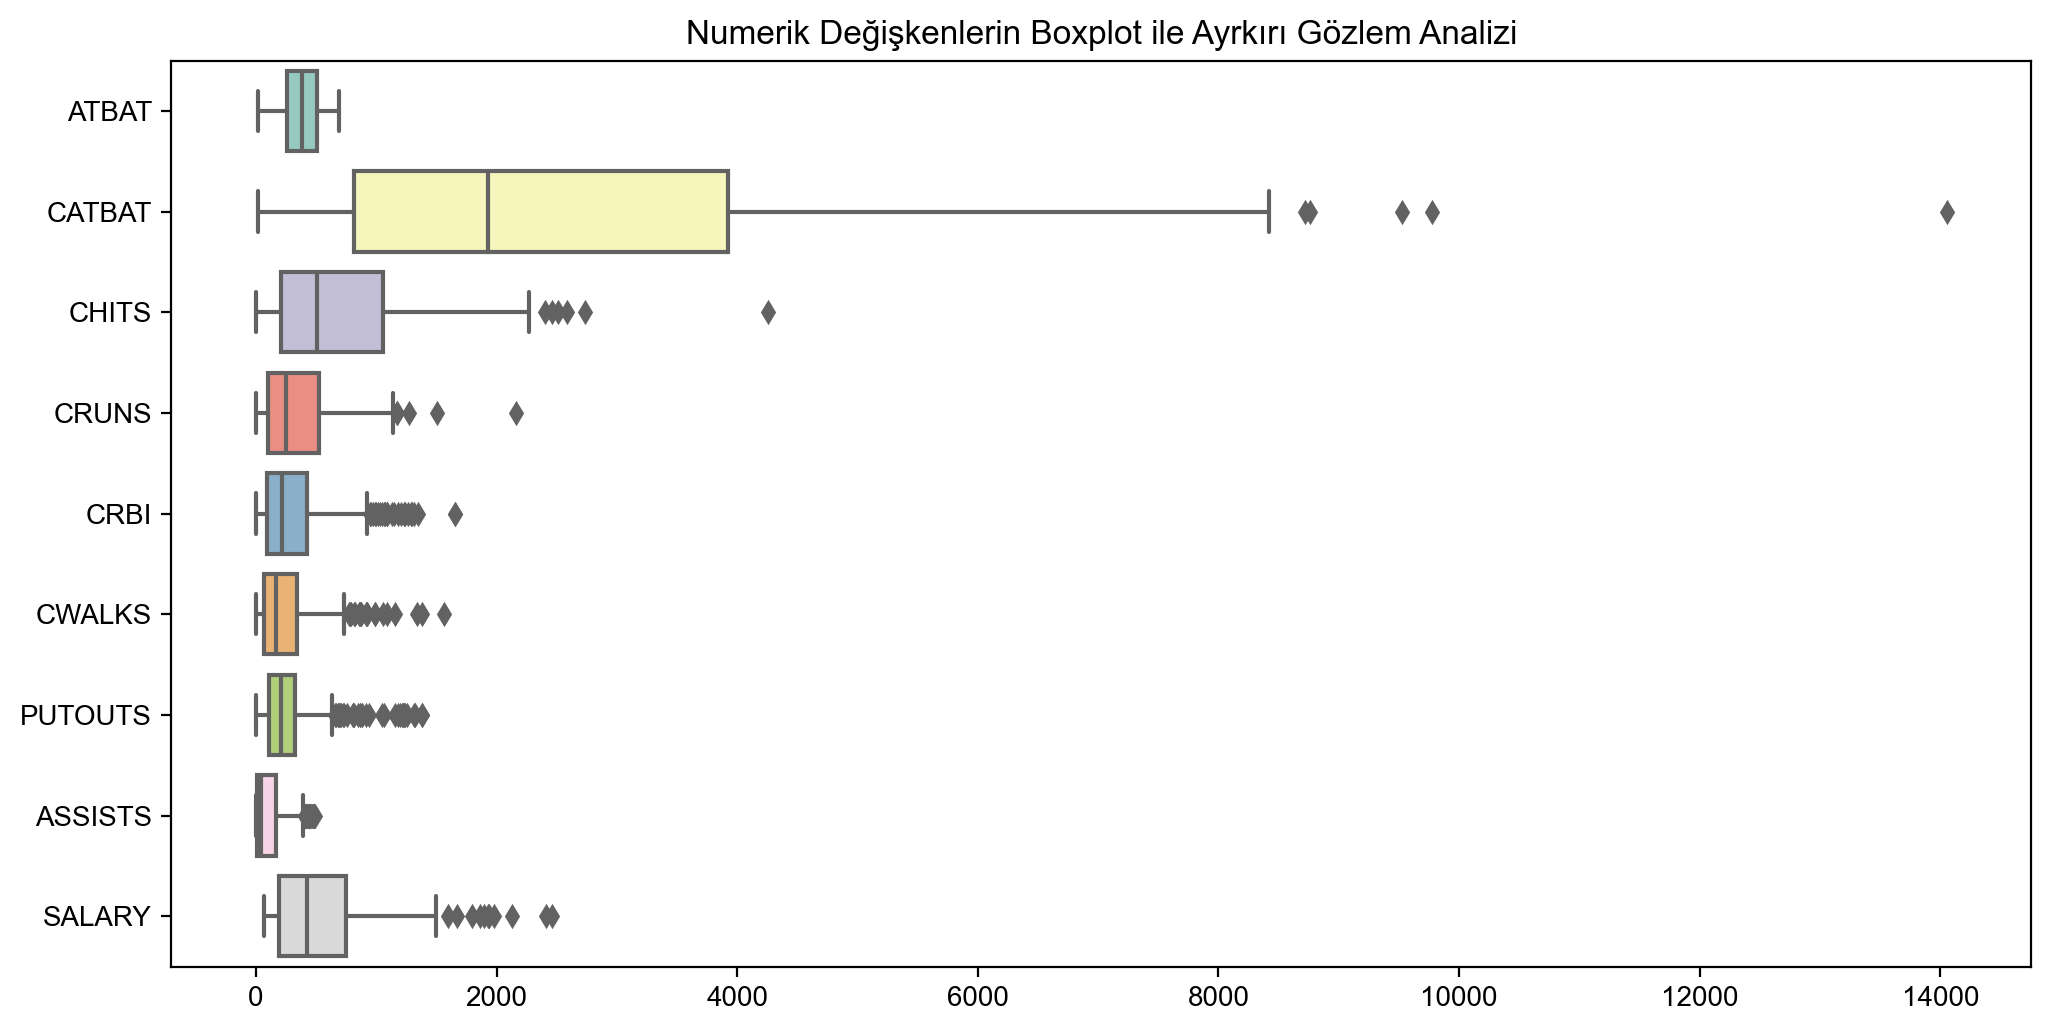

In [30]:
outliers_boxplot(df, high_cols)  # Yüksek değerlikli nümerik değişkenlerin aykırı gözlem analizi

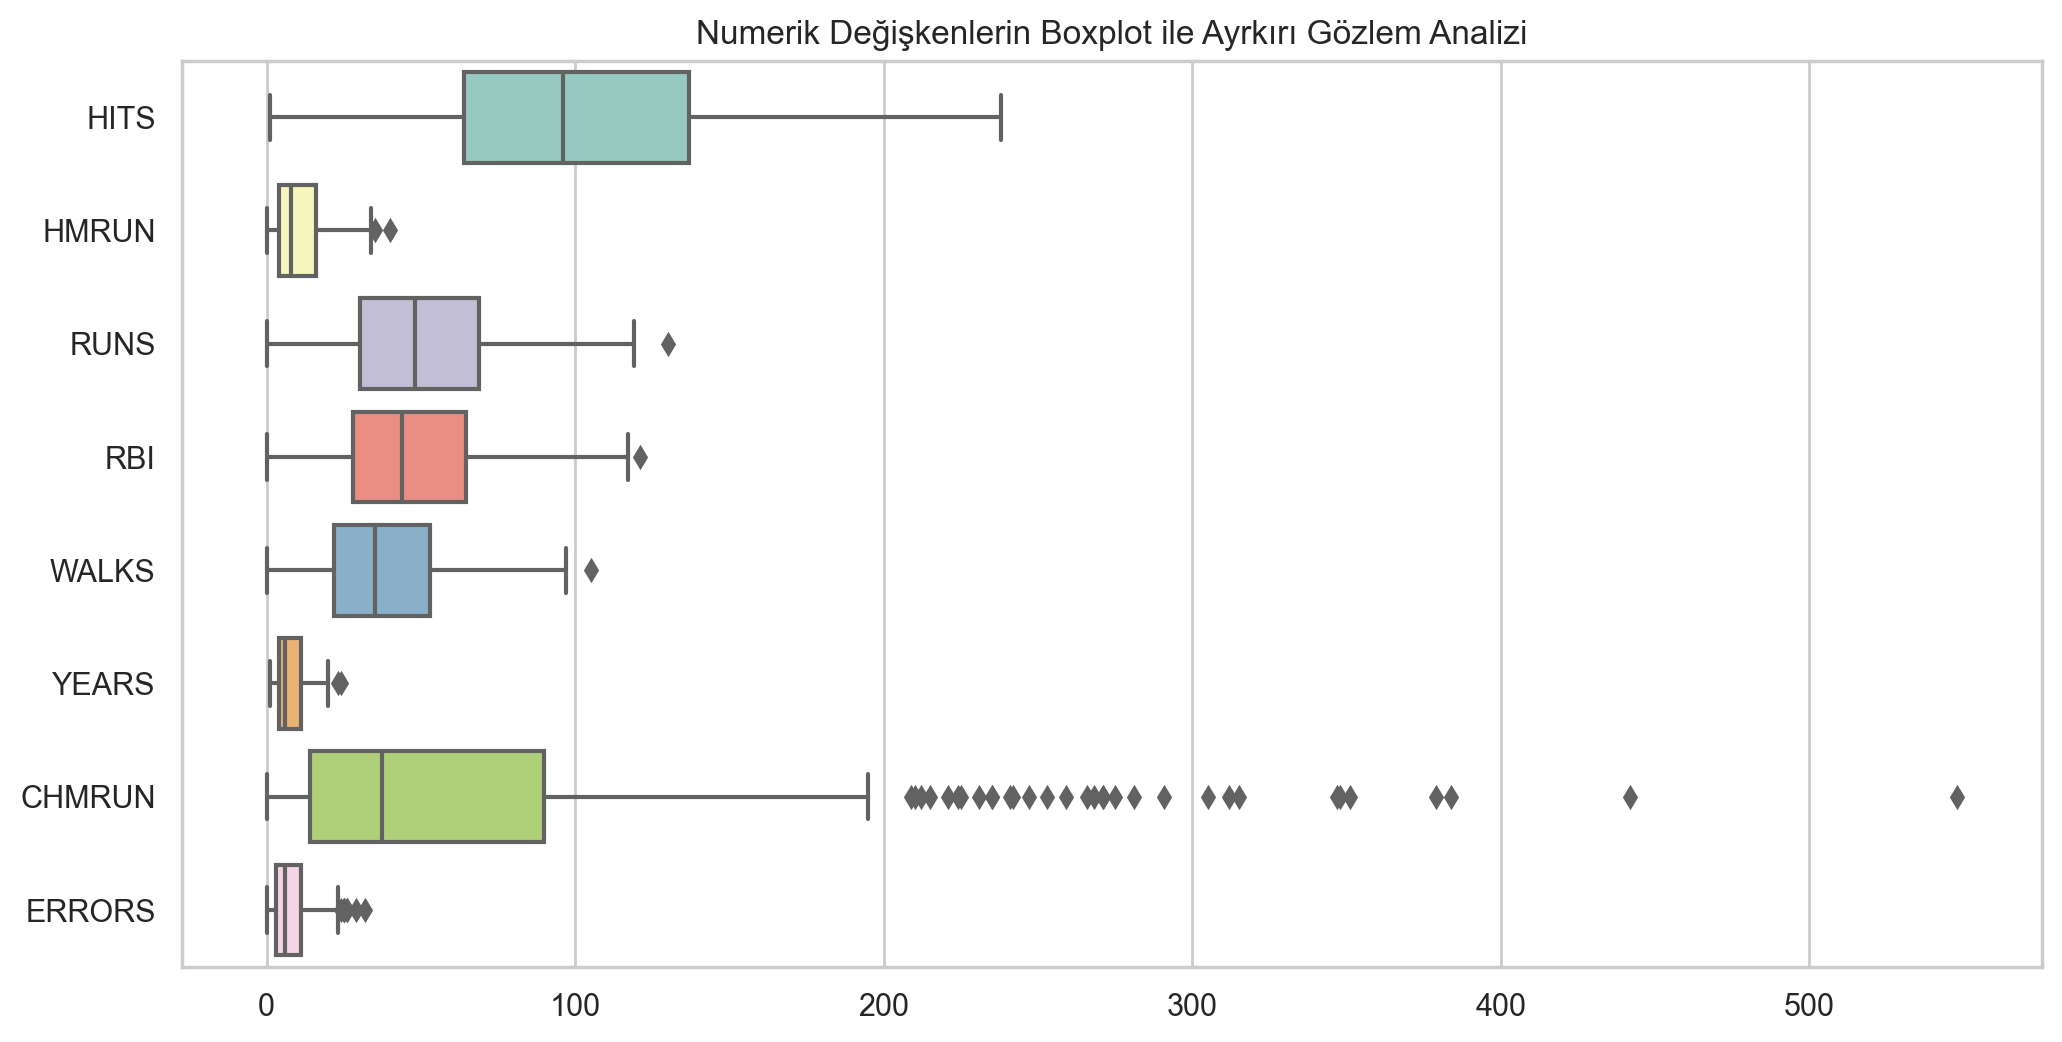

In [31]:
outliers_boxplot(df, low_cols)  # Düşük değerlikli nümerik değişkenlerin aykırı gözlem analizi

Görüldüğü gibi birçok nümerik değişkende outliers görülmektedir. 

##### Sayısal olarak inceleme

outlier_thresholds(), değişkenin outlier threshold değerlerini hesaplayan fonksiyondur

In [32]:
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

check_outlier(), değişkende outlier olup olmadığını dönen fonksiyondur

In [33]:
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [34]:
outliers_list = []
for col in num_cols:
    check_return = check_outlier(df, col)
    print(f"{col}:", check_return)
    if check_return:
        outliers_list.append(col)   # Outlier değişkenler liste olarak tutulur.

ATBAT: False
HITS: False
HMRUN: True
RUNS: True
RBI: True
WALKS: True
YEARS: True
CATBAT: True
CHITS: True
CHMRUN: True
CRUNS: True
CRBI: True
CWALKS: True
PUTOUTS: True
ASSISTS: True
ERRORS: True
SALARY: True


Outlier gözlem bulunduran tüm değişkenlere True olarak görülebilir.

## 1.5-Eksik Gözlem Analizi

In [35]:
df.isnull().values.any() # Veri setinde eksik gözlem(missing value) var mı?

True

Missing value gözlem değerlerine sahip değişkenler var.

missing_values_table(), missing value gözlemlere sahip değişkenleri, missing value sayısını ve ortalamasını dönen fonksiyondur.

In [36]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")
    if na_name:
        return na_columns

In [37]:
missing_values_table(df, na_name=True)

        n_miss  ratio
SALARY      59 18.320


['SALARY']

Bağımlı değişkende missing value değerleri görülmekte.

# 2-Feature Engineering (Özellik Mühendisliği)

Buraya kadarki kısım, Veri setine ilk bakışla ilgiliydi. EDA olarak da tanımlanan buraya kadarki kısımda veri üzerinde herhangi bir değişiklik yapılmadı.

Feature Engineering bölümüyle ile birlikte veri seti, geliştirilecek model için sayısallaştırılacaktır.

## 2.1-Eksik ve Aykırı Değerleri Düzeltme

Bu bölümde, veri setinde eksik gözlemlere sahip değişkenler baskılama yöntemiyle düzeltiliyor olacak. 

### 2.1.1-Aykırı Değerlerin Düzeltilmesi

In [38]:
outliers_list  # Aykırı değer gözlemler barındıran değişkenlerin listesi

['HMRUN',
 'RUNS',
 'RBI',
 'WALKS',
 'YEARS',
 'CATBAT',
 'CHITS',
 'CHMRUN',
 'CRUNS',
 'CRBI',
 'CWALKS',
 'PUTOUTS',
 'ASSISTS',
 'ERRORS',
 'SALARY']

replace_with_thresholds() veri setindeki outlier değerleri belirlenen threshold değerine göre baskılayan fonksiyondur.

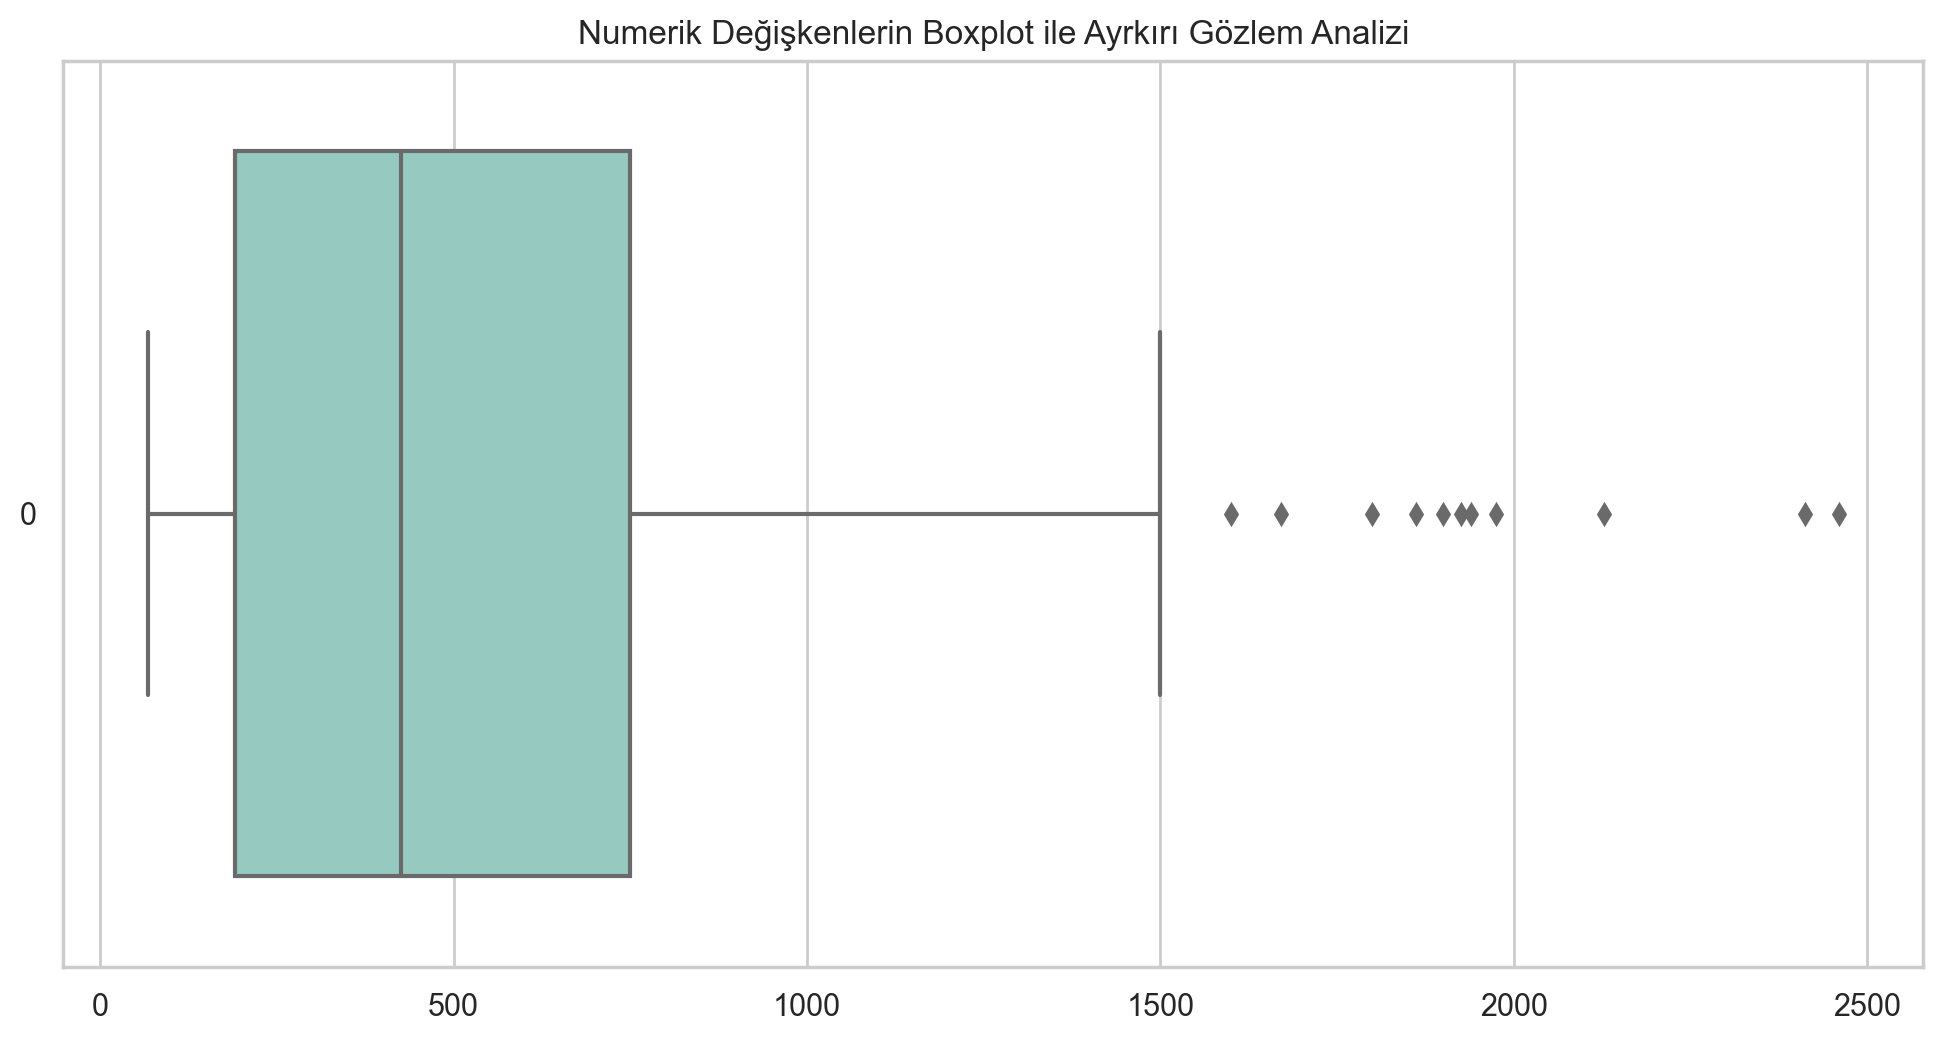

In [39]:
outliers_boxplot(df, "SALARY")

Salary değişkenindeki outliers ve NaN değişkenleri baskılamaMAMız lazım. 

In [40]:
df = df[(df['SALARY'] < 1350) | (df['SALARY'].isnull())] 

In [41]:
check_outlier(df, "SALARY")

False

In [42]:
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [43]:
outliers_list = []
for col in num_cols:
    check_return = check_outlier(df, col)
    print(f"{col}:", check_return)
    if check_return:
        outliers_list.append(col)   # Outlier değişkenler liste olarak tutulur.

ATBAT: False
HITS: False
HMRUN: True
RUNS: False
RBI: True
WALKS: False
YEARS: True
CATBAT: True
CHITS: True
CHMRUN: True
CRUNS: True
CRBI: True
CWALKS: True
PUTOUTS: True
ASSISTS: True
ERRORS: True
SALARY: False


In [44]:
outliers_list

['HMRUN',
 'RBI',
 'YEARS',
 'CATBAT',
 'CHITS',
 'CHMRUN',
 'CRUNS',
 'CRBI',
 'CWALKS',
 'PUTOUTS',
 'ASSISTS',
 'ERRORS']

In [45]:
for col in outliers_list:
    replace_with_thresholds(df, col)

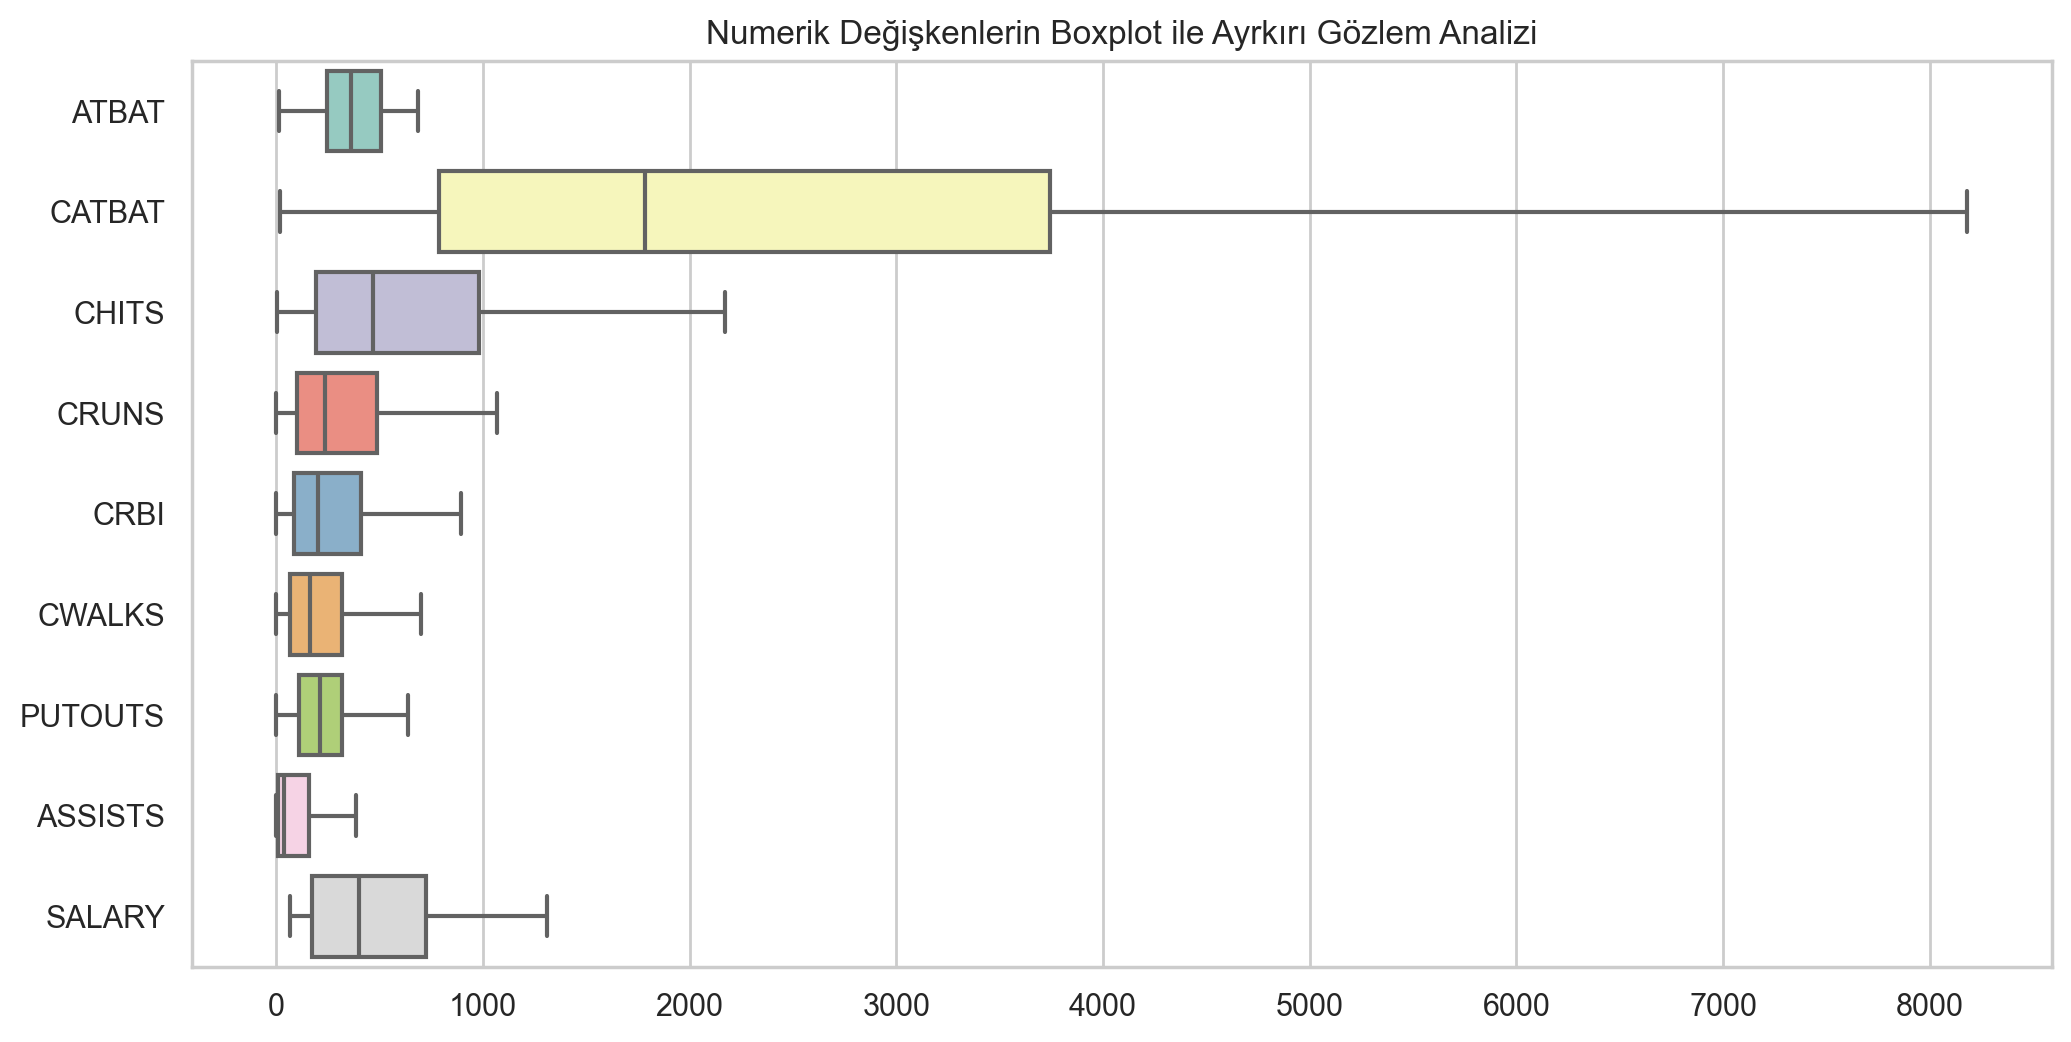

In [46]:
outliers_boxplot(df, high_cols)

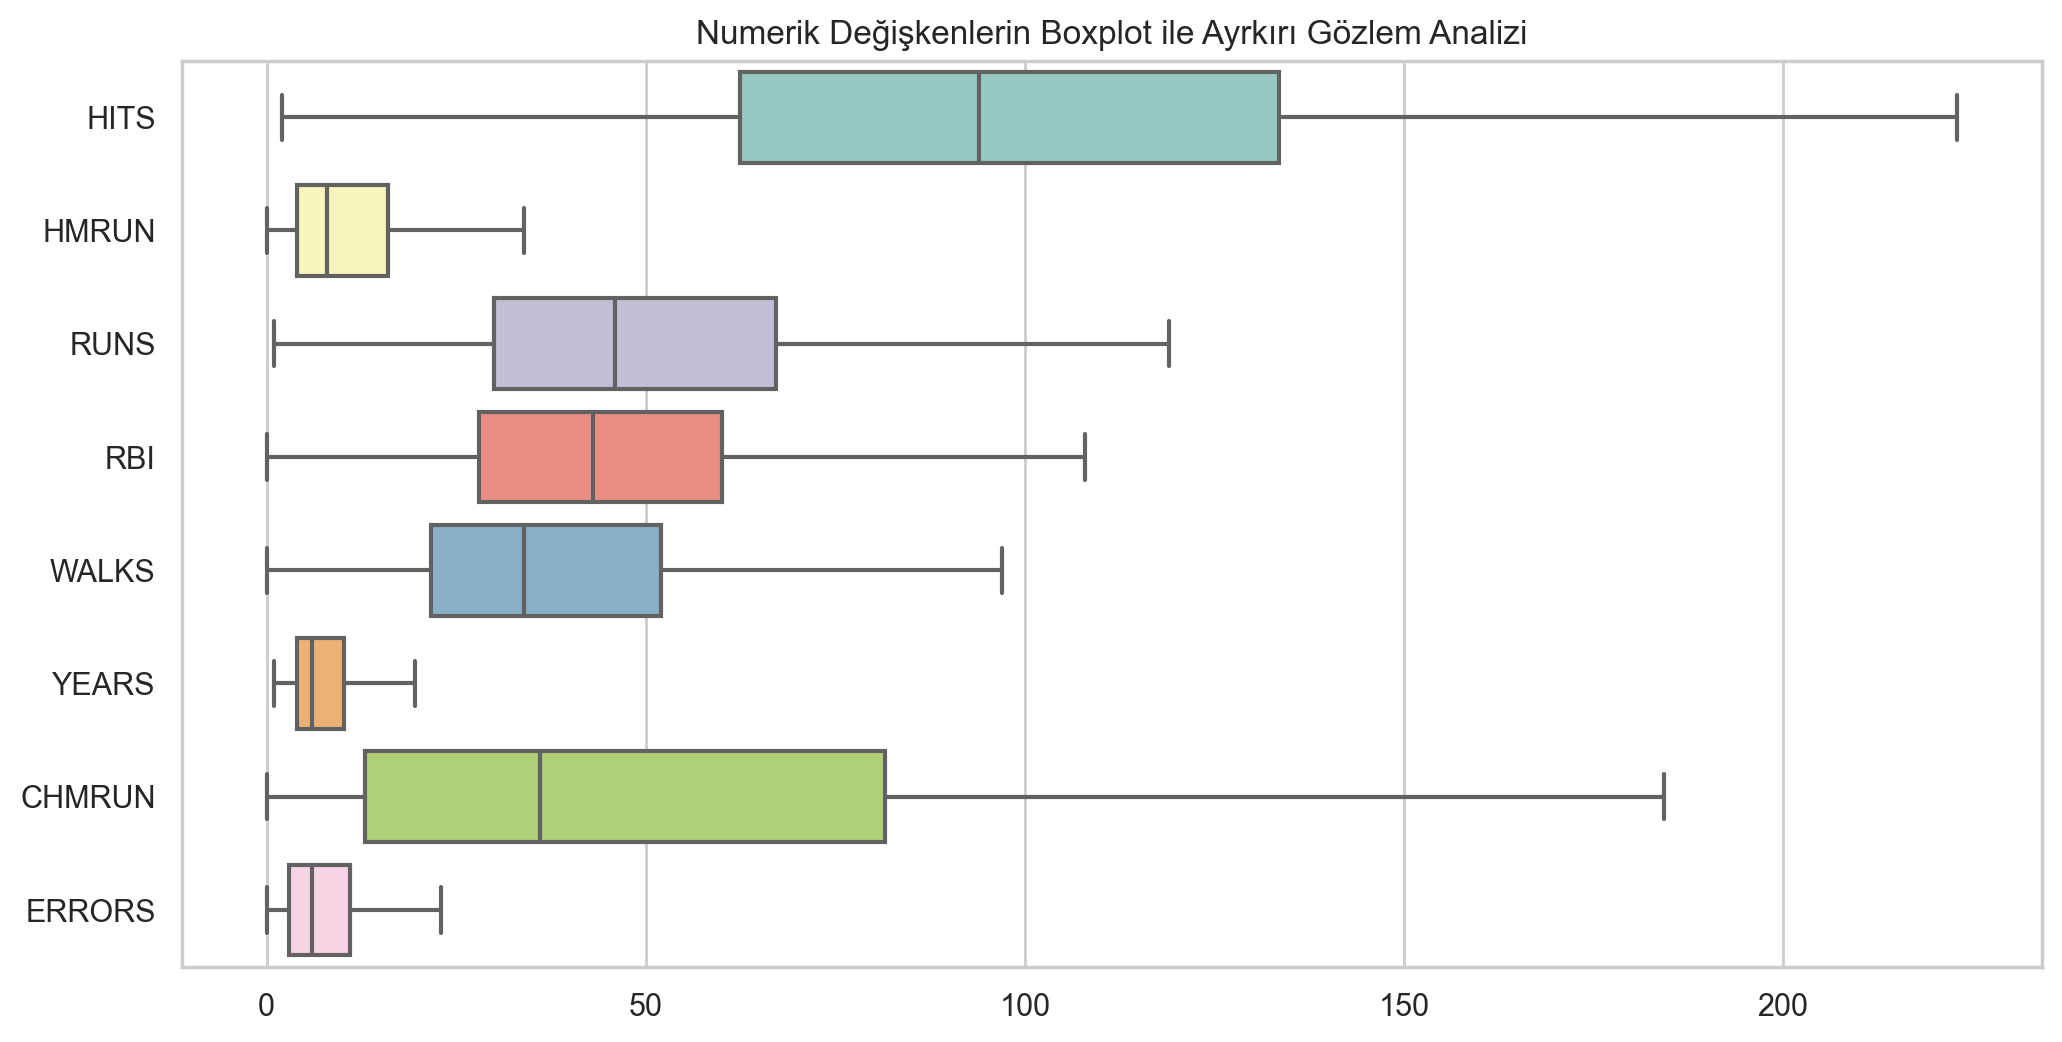

In [47]:
outliers_boxplot(df, low_cols)

Görüldüğü üzere değişkenler üzerindeki outlier gözlemler baskılandı.

### 2.1.2-Eksik Değerlerin Düzeltilmesi

## 2.2-Yeni Değişkenler Türetme (Feature Extraction)

Bu bölüm, Keşifçi Veri Analizi bölümünde ele alınan değişkenlerin bağımlı değişken ile olan ilişkisi üzerinden, yeni değişkenler türetme aşamasıdır.

Var olan değişkenler üzerinden türetilecek olan yeni değişkenlerle, bağımlı değişken ile arasında anlamlı çıkarımlar kurulması amaçlanacaktır.

In [48]:
df.head()

,ATBAT,HITS,HMRUN,RUNS,...,ASSISTS,ERRORS,SALARY,NEWLEAGUE
0,293,66,1,30,...,33.000,20,NaN,A
1,315,81,7,24,...,43.000,10,475.000,N
2,479,130,18,66,...,82.000,14,480.000,A
3,496,141,20,65,...,11.000,3,500.000,N
4,321,87,10,39,...,40.000,4,91.500,N


Bu bölümde türeteceğimiz yeni değişkenler için bağımlı değişkenle arasındaki yüksek korelasyon kriteri dikkate alınarak yapılacaktır.

### 2.2.1-Kategorik Değişkenler Türetme

Bağımsız değişkenlerden kategorik türde yeni değişkenlerin türetilmesi aşamasıdır. Değişkenler segmentlere ayrılacaktır.

##### YEARS Değişkeni ile Kategorik Değişken Türetme

Years: Oyuncunun major liginde oynama süresini ifade etmektedir. Oyuncunun, SALARY bağımlı değişkenine doğrudan ve diğer değişkenler üzerinde de dolaylı olarak etkileyebilecek bir değişkendir. Bir oyuncunun ilgili ligdeki skorlarını, tüm kariyerindeki skorları üzerinden yorumlanırken YEARS değişkeni göz önünde tutulacaktır.

In [49]:
df["YEARS"].describe()

count   308.000
mean      7.297
std       4.839
min       1.000
25%       4.000
50%       6.000
75%      10.250
max      19.625
Name: YEARS, dtype: float64

In [50]:
df.loc[(df["YEARS"] <= 1), "NEW_YEARS_Cat"] = "Begginer"
df.loc[(df["YEARS"] > 1) & (df['YEARS'] <= 4), "NEW_YEARS_Cat"] = "Junior"
df.loc[(df["YEARS"] > 4) & (df['YEARS'] <= 8), "NEW_YEARS_Cat"] = "Mid"
df.loc[(df["YEARS"] > 8) & (df['YEARS'] <= 12), "NEW_YEARS_Cat"] = "Senior"
df.loc[(df["YEARS"] > 12), "NEW_YEARS_Cat"] = "Expert"

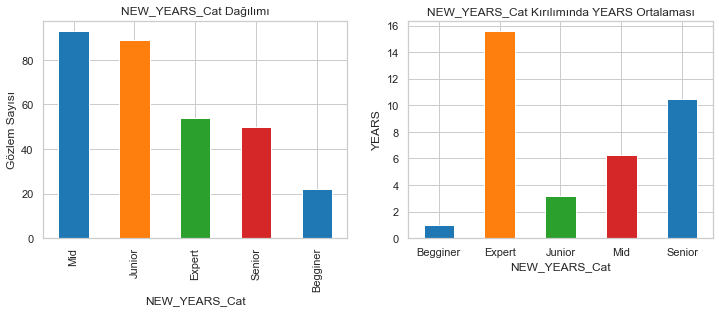

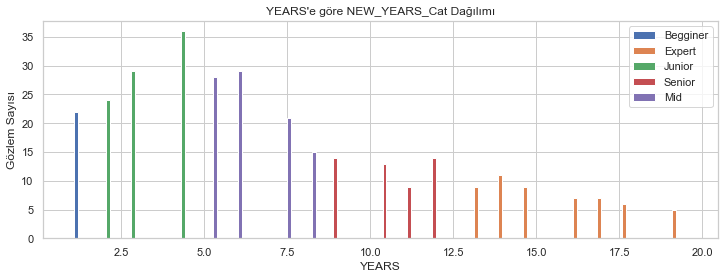

In [51]:
cat_analyser_plot(df, "NEW_YEARS_Cat", "YEARS")

Grafikten anlaşılacağı üzere, veri setinde yeni deneyim sahibi(Begginer, Junior) oyuncular çoğunlukta. Buna karşın, beklenildiği gibi deneyimli oyuncuların SALARY ortalaması daha yüksek. Buradan, bağımlı değişkenin belirlenmesinde oyuncu deneyiminin etkili olduğu söylenebilir.

##### HITS Değişkeni ile Kategorik Değişken Türetme

HITS: Oyuncunun 1986-1987 sezonundaki isabet sayısını ifade etmektedir. Bağımlı değişken(SALARY) üzerinde doğrudan etkili olan bu değişken farklı segmentlere ayrılarak bağımlı değişken üzerindeki anlamlılığı ayrıntılı bir şekilde gözlemlenecektir.

In [52]:
df["HITS"].describe()

count   308.000
mean     98.620
std      44.708
min       2.000
25%      62.500
50%      94.000
75%     133.500
max     223.000
Name: HITS, dtype: float64

In [53]:
df["NEW_Hit_Class"] = pd.qcut(df['HITS'], 4, labels=['poor','average','star','super_star'])

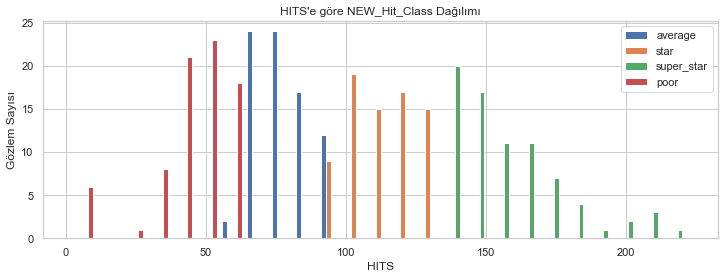

In [54]:
cat_distribution_plot(df, "NEW_Hit_Class", "HITS")

Yeni türetilen NEW_Hit_class değişkenin dağılımını gösteren grafik. Dağılımın normal dağılıma yakın olduğu gözlenebilir. Buna marjinal kategorideki(poor, super_star) oyuncular azınlıkta.

##### LEAGUE Değişkeni ile Kategorik Değişken Türetme

LEAGUE: Oyuncunun sezon sonuna kadar oynadığı ligi gösteren A ve N seviyelerine sahip bir faktördür.

1986-1987 sezonu sonunda lig değiştiren oyuncular:

In [55]:
df.loc[(df["LEAGUE"] != df["NEWLEAGUE"]), "NEW_CHANGE_LEAGUE"] = 1
df.loc[(df["LEAGUE"] == df["NEWLEAGUE"]), "NEW_CHANGE_LEAGUE"] = 0

In [56]:
cat_summary(df, "NEW_CHANGE_LEAGUE", "SALARY")

       NEW_CHANGE_LEAGUE  Ratio  SALARY_Mean
0.000                289 93.831      457.366
1.000                 19  6.169      518.056


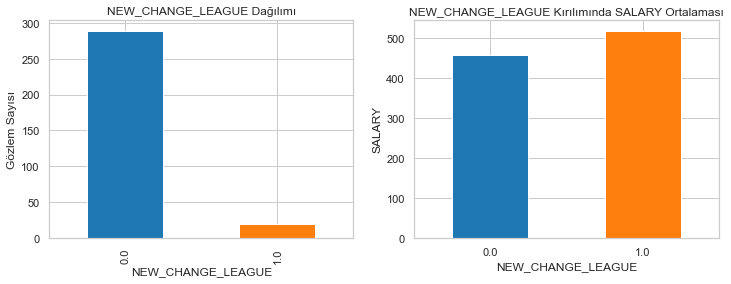

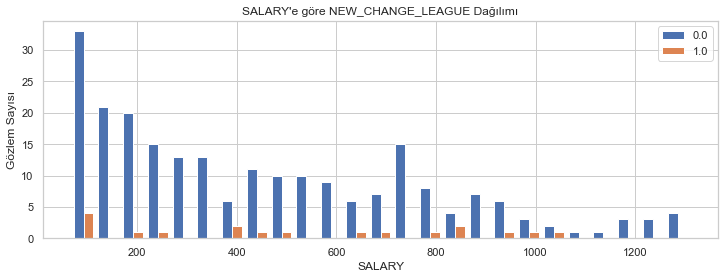

In [57]:
cat_analyser_plot(df, "NEW_CHANGE_LEAGUE", "SALARY")

Grafiklerden anlaşılacağı üzere, veri setinde sezon bitiminde lig değiştirmeyen oyuncular baskın bir şekilde çoğunluktayken, lig değiştiren azınlık oyuncularla ortalama aynı SALARY aldıklarını söyleyebiliriz. Buna göre, lig değişimi bağımlı değişken için önemli bir faktör olabilir. Lig değiştiren oyuncu yüzdesi oldukça az olduğundan(%6) rare olarak anlamsız bir değişken olarak da görülebilir.

### 2.2.2-Nümerik Değişkenler Türetme

Bağımsız değişkenlerden nümerik türde yeni değişkenlerin türetilmesi aşamasıdır. Değişkenler arasındaki oranlar dikkate alınacaktır.

create_ratio_cols(), iki değişkenin oranını alıp isimlendirerek yeni değişken oluşturan bir fonksiyondur.

In [58]:
def create_ratio_cols(dataframe, numerator_col, denominator_col, new_col_name=False):        
    if new_col_name:  # yeni dataframe'in adlandırılması fonksiyonda
        dataframe[new_col_name] = dataframe[numerator_col]/(dataframe[denominator_col]+0.001) 
    else:              # Bölme sonucu paydanın sıfır olması durumunda sonsuz çıkmaması için 0.001 eklendi.
        dataframe[f"NEW_{numerator_col}/{denominator_col}"] = dataframe[numerator_col]/(dataframe[denominator_col]+0.0001)

##### YEARS Değişkeni ile Nümerik Değişken Türetme

Oyuncunun kariyeri boyunca ortalama isabetli atış sayısı:

In [59]:
create_ratio_cols(df, "CHITS", "YEARS", "NEW_CRBI/YEARS")

Oyuncunun kariyeri boyunca ortalama yaptığı en değerli atış sayısı:

In [60]:
create_ratio_cols(df, "CHMRUN", "YEARS")

Oyuncular ait diğer değişkenlerin zamana bağlı oranları nelerdir?

In [61]:
create_ratio_cols(df, "CHITS", "YEARS")
create_ratio_cols(df, "CRUNS", "YEARS")
create_ratio_cols(df, "CRBI", "YEARS")
create_ratio_cols(df, "CATBAT", "YEARS")

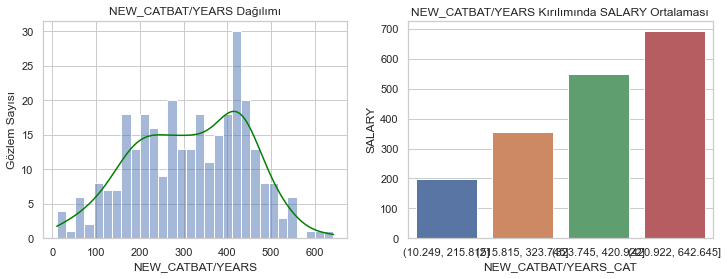

In [62]:
num_analyser_plot(df, "NEW_CATBAT/YEARS", "SALARY")

Yeni oluşturulan NEW_CATBAT/YEARS değişkenine ait grafikler. Buna göre, oyuncunun kariyeri boyunca topa vurma ortalamasının SALARY üzerinde doğrudan etkili olduğunu söyleyebiliriz.

##### HITS Değişkeni ile Nümerik Değişken Türetme

HITS: Oyuncunun 1986-1987 sezonundaki toplam isabet sayısını ifade etmektedir.

Oyuncunun, toplam topa vuruş sayısına göre isabet oranı nedir? 

In [63]:
create_ratio_cols(df, "HITS", "ATBAT")

Oyuncunun kariyeri boyunca topa vurma sayısına göre isabetli vuruş oranı nedir?

In [64]:
create_ratio_cols(df, "CHITS", "CATBAT")

##### RUNS Değişkeninden Yeni Değişkenler Türetme

RUNS: Oyuncunun, 1986-1987 sezonunda takımına kazandırdığı sayı ifade etmektedir. Beklenildiği gibi, bağımlı değişkenle olan korelasyonuna bakıldığında oyuncunun SALARY değerini etkileyen önemli bir parametre olduğu görülebilir. Bu değişkenle ilişkili başka değişkenler türetmek, kurulacak model için anlamlı bilgi taşıyabilir. 

Oyuncunun 1986-1987 sezonunda topa yaptığı vuruş sayısına göre takımına kazandırdığı sayı oranı nedir? 

In [65]:
create_ratio_cols(df, "RUNS", "CRUNS")

Oyuncunun, toplam topa yaptığı vuruş sayısına oranla takımına kazandırdığı sayı oranı nedir?

In [66]:
create_ratio_cols(df, "RUNS", "ATBAT")  

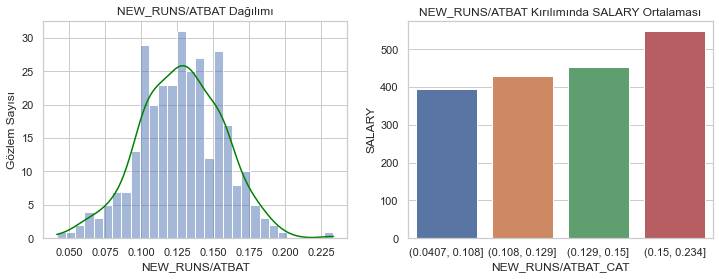

In [67]:
num_analyser_plot(df, "NEW_RUNS/ATBAT", "SALARY")

Türetilen NEW_RUNS/ATBAT değişkeninin yukarıdaki grafikten dağılımı incelendiğinde, oyuncunun toplam topa vuruş sayısına göre takımına kazandırdığı sayı oranı arttıkça ortalama maaşı(SALARY) artmaktadır.

Oyuncunun kariyeri boyunca yaptığı isabetli atışlardan kaçı takımına sayı kazandırdı? 

In [68]:
create_ratio_cols(df, "CRUNS", "CHITS") 

Oyuncunun ilgili sezonda takımına kazandırdığı sayılara oranla, en değerli vuruş sayısı nedir?

In [69]:
create_ratio_cols(df, "HMRUN", "RUNS")

Oyuncunun kariyeri boyunca takımına kazandırdığı sayılara oranla, kariyeri boyunca yaptığı en değerli vuruş sayısı nedir?

In [70]:
create_ratio_cols(df, "CHMRUN", "CRUNS")

##### RBI Değişkeninden Yeni Değişkenler Türetme

RBI: Vurucu rolündeki oyuncunun vuruş yaptıgında koşu yaptırdığı oyuncu sayısını ifade etmektedir. Değişkenler arasındaki korelasyondan anlaşılacağı üzere bir oyuncunun koşu yaptırdığı oyuncu sayısı, SALARY değişkeninde önemli bir faktör. Buna göre, RBI değişkeni kullanılark yeni değişkenler türetilerek anlamlılığı irdelenecek.

Oyuncunun kariyerinde koşu yaptırdığı oyuncu sayısına göre sezondaki sayısı nedir?

In [71]:
create_ratio_cols(df, "RBI", "CRBI")

Oyuncunun, kariyerindeki isabetli atışlarından koşu yaptırdığı oyuncu oranı nedir?

In [72]:
create_ratio_cols(df, "CRBI", "CHITS") # Sorun çıkmadı

Oyuncunun, 1986-1987 sezonunda topa yaptığı vuruş sayısına göre koşu yaptırdığı oyuncu sayısı nedir?

In [73]:
create_ratio_cols(df, "RBI", "ATBAT") # arttırdı ama kalabilir

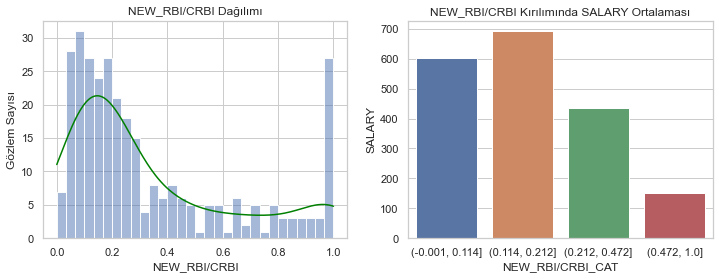

In [74]:
num_analyser_plot(df, "NEW_RBI/CRBI", "SALARY")

Grafiklere göre, oyuncunun sezondaki toplam topa vuruş sayısına göre koşu yaptırdığı oyuncu oranı arttıkça SALARY değeri azalmaktadır. Türetilen buu değişkenle bağımlı değişken arasında negatif yönlü doğrusal bir ilişki görülmektedir.

##### WALKS Değişkeninden Yeni Değişkenler Türetme

WALKS: Karşı oyuncuya yaptırılan hata sayısını ifade etmektedir.

Oyuncunun, ilgili yıllarda kariyerine göre karşı oyuncuya yaptırdığı hata sayısı oranı. (İlgili sezonda karşı takıma yaptırdığı hata sayı / kariyerindeki toplam yaptırdığı hata sayısı)

In [75]:
create_ratio_cols(df, "WALKS", "CWALKS")

Oyuncunun, karşı oyuncuya yaptırdığı hata sayısına bağlı olarak en değerli vuruş sayısı oranı:

In [76]:
create_ratio_cols(df, "WALKS", "HMRUN")  

Oyuncunun kariyeri boyunca karşı takım oyuncusuna yaptırdığı hata ortalaması nedir?

In [77]:
create_ratio_cols(df, "CWALKS", "YEARS")

##### ATBAT Değişkeninden Yeni Değişkenler Türetme

ATBAT: Oyuncunun 1986-1987 sezonunda bir beyzbol sopası ile topa yaptığı vuruş sayısını ifade etmektedir. 

Oyuncunun kariyeri boyunca yaptığı atışa göre 1986-1987 sezonunda yaptığı atış oranı nedir?

In [78]:
create_ratio_cols(df, "ATBAT", "CATBAT")

Oyuncun 1986-1987 sezonunda yaptığı hataların kaçı vuruşlarından kaynaklıdır?

In [79]:
create_ratio_cols(df, "ATBAT", "ERRORS") 

##### Diğer Değişkenlerden Yeni Değişkenler Türetme 

Oyuncunun kariyerine göre, toplam en değerli vuruş sayısının ilgili sezondakine oranı nedir?

In [80]:
create_ratio_cols(df, "HMRUN", "CHMRUN")

Oyuncunun kariyerine göre, toplam isabetli vuruş sayısının ilgili sezondakine oranı nedir?

In [81]:
create_ratio_cols(df, "CHMRUN", "CHITS")

Oyyncunun kariyeri boyunca topa vurma sayısına oranla yaptığı en değerli vuruş sayısı kaçtır?

In [82]:
create_ratio_cols(df, "CHMRUN", "CATBAT") 

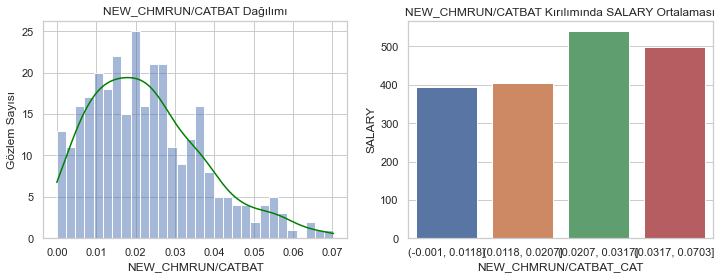

In [83]:
num_analyser_plot(df, "NEW_CHMRUN/CATBAT", "SALARY")

Oyuncunun toplam topa vuruşlarına göre en değerli sayısı oranı doğrudan SALARY üzerinde etkisi baskın gözükmese de dağılımdaki çarpıklık anlamlılık taşıyor olabilir.

## 2.3-Encoding işlemlerini gerçekleştirme

Bu bölüm, veri setindeki kategorik değişkenlerin model tarafından anlaşılabilir formatta olacak şekilde encode edilmesi aşamasıdır. Sırasıyla Label Encoding, Rare Encoding ve One-Hot Encoding işlemleri yapılacaktır.

### 2.3.1-Label Encoder

2 farklı deişkene sahip kategorik değişkenlerin binary(0-1) haline çevrilmesi aşamasıdır.

In [84]:
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

In [85]:
binary_cols = [col for col in df.columns if df[col].dtype == "O" and df[col].nunique() == 2] 
binary_cols

['LEAGUE', 'DIVISION', 'NEWLEAGUE']

In [86]:
for col in binary_cols:
    df = label_encoder(df, col)
df.head(2)

,ATBAT,HITS,HMRUN,RUNS,...,NEW_ATBAT/ERRORS,NEW_HMRUN/CHMRUN,NEW_CHMRUN/CHITS,NEW_CHMRUN/CATBAT
0,293,66,1,30,...,14.650,1.000,0.015,0.003
1,315,81,7,24,...,31.500,0.101,0.083,0.020


### 2.3.2-Rare Encoding

Bağımlı değişkene göre dağılımı seyrek olan değişken gözlemlerinin birarada encode edilmesidir.

In [87]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

In [88]:
def rare_analyser(dataframe, target, cat_cols):
    for col in cat_cols:
        print(col, ":", len(dataframe[col].value_counts()))
        print(pd.DataFrame({"COUNT": dataframe[col].value_counts(),
                            "RATIO": dataframe[col].value_counts() / len(dataframe),
                            "TARGET_MEAN": dataframe.groupby(col)[target].mean()}), end="\n\n\n")

In [89]:
rare_analyser(df, "SALARY", cat_cols)

NEW_YEARS_Cat : 5
          COUNT  RATIO  TARGET_MEAN
Begginer     22  0.071      149.647
Expert       54  0.175      622.398
Junior       89  0.289      217.410
Mid          93  0.302      579.900
Senior       50  0.162      637.662


LEAGUE : 2
   COUNT  RATIO  TARGET_MEAN
0    167  0.542      461.901
1    141  0.458      461.590


DIVISION : 2
   COUNT  RATIO  TARGET_MEAN
0    146  0.474      503.467
1    162  0.526      424.179


NEWLEAGUE : 2
   COUNT  RATIO  TARGET_MEAN
0    168  0.545      457.925
1    140  0.455      466.144


NEW_Hit_Class : 4
            COUNT  RATIO  TARGET_MEAN
poor           77  0.250      281.770
average        79  0.256      371.151
star           75  0.244      492.231
super_star     77  0.250      633.523


NEW_CHANGE_LEAGUE : 2
       COUNT  RATIO  TARGET_MEAN
0.000    289  0.938      457.366
1.000     19  0.062      518.056




Rare olarak kabul edilebilecek (ratio < 0.01 seviyede) herhangi bir değişken gözlemi gözükmüyor.

### 2.3.3-One-Hot Encoding

2'den fazla benzersiz(uniq) gözleme sahip kategorik değişkenlerin encode edilmesi aşamasıdır.

In [90]:
ohe_cols = [col for col in df.columns if 10 >= df[col].nunique() > 2]  # One-Hot encoding için uygun değişkenler
ohe_cols

['NEW_YEARS_Cat', 'NEW_Hit_Class']

In [91]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=True):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

In [92]:
df = one_hot_encoder(df, ohe_cols)

### 2.3.4-Numerik Değişkenler için Standartlaştırma İşlemi

Lineer Regresyon uzaklık temelli bir model tekniği olduğundan, değişkenler arasındaki yüksek oranların yanlılık yaratmaması için belirli seviyede standartlaştırılması gerekmektedir. Bu aşamada nümerik değişkenlerin standartlaştırılması yapılacaktır.

In [93]:
#cat_cols, num_cols, cat_but_car = grab_col_names(df)  # Nümerik değişkenleri kullanacağız.

In [94]:
#num_cols.remove("SALARY")

In [95]:
#scaler = StandardScaler()
#df[num_cols] = scaler.fit_transform(df[num_cols])

In [96]:
df.head(3)    # Encoding sonrası veri seti

,ATBAT,HITS,HMRUN,RUNS,...,NEW_YEARS_Cat_Senior,NEW_Hit_Class_average,NEW_Hit_Class_star,NEW_Hit_Class_super_star
0,293,66,1,30,...,0,1,0,0
1,315,81,7,24,...,0,1,0,0
2,479,130,18,66,...,0,0,1,0


In [97]:
df.shape

(308, 51)

Modelden oluşturmadan önce, Feature Extraction aşamasında dataframe değişken sayısının 20'den 49'a çıkarıldığı görülebilir.

# 3-Model oluşturma ve Test

In [329]:
df_null = df[df["SALARY"].isnull()] 
df.dropna(inplace=True)  

In [214]:
y = df["SALARY"]
X = df.drop(["SALARY"], axis=1)

In [215]:
y.head()

1   475.000
2   480.000
3   500.000
4    91.500
5   750.000
Name: SALARY, dtype: float64

In [220]:
models = [('LR', LinearRegression()),
          ("Ridge", Ridge()),
          ("Lasso", Lasso()),
          ("ElasticNet", ElasticNet()),
          ('KNN', KNeighborsRegressor()),
          ('CART', DecisionTreeRegressor()),
          ('RF', RandomForestRegressor()),
          ('SVR', SVR()),
          ('GBM', GradientBoostingRegressor()),
          ("XGBoost", XGBRegressor(objective='reg:squarederror')),
          ("LightGBM", LGBMRegressor()),
          #("CatBoost", CatBoostRegressor(verbose=False))
         ]

In [221]:
for name, regressor in models:
    rmse = np.mean(np.sqrt(-cross_val_score(regressor, X, y, cv=10, scoring="neg_mean_squared_error")))
    print(f"RMSE: {round(rmse, 4)} ({name}) ")

RMSE: 224.9057 (LR) 
RMSE: 210.7909 (Ridge) 
RMSE: 209.4261 (Lasso) 
RMSE: 228.0749 (ElasticNet) 
RMSE: 221.5555 (KNN) 
RMSE: 254.9291 (CART) 
RMSE: 185.034 (RF) 
RMSE: 331.9467 (SVR) 
RMSE: 194.8371 (GBM) 
RMSE: 201.9083 (XGBoost) 
RMSE: 191.7503 (LightGBM) 


In [222]:
cart_params = {'max_depth': range(1, 20),
               "min_samples_split": range(2, 30)}

rf_params = {"max_depth": [5, 8, 15, None],
             "max_features": [5, 7, "auto"],
             "min_samples_split": [8, 15, 20],
             "n_estimators": [200, 500, 1000]}

xgboost_params = {"learning_rate": [0.1, 0.01, 0.01],
                  "max_depth": [5, 8, 12, 20],
                  "n_estimators": [100, 200, 300, 500],
                  "colsample_bytree": [0.5, 0.8, 1]}

lightgbm_params = {"learning_rate": [0.01, 0.1, 0.001],
                   "n_estimators": [300, 500, 1500],
                   "colsample_bytree": [0.5, 0.7, 1]}

In [341]:
regressors = [("CART", DecisionTreeRegressor(), cart_params),
              ("RF", RandomForestRegressor(), rf_params),
              ('XGBoost', XGBRegressor(objective='reg:squarederror'), xgboost_params),
              ('LightGBM', LGBMRegressor(), lightgbm_params)]

best_models = {}

In [224]:
for name, regressor, params in regressors:
    print(f"########## {name} ##########")
    rmse = np.mean(np.sqrt(-cross_val_score(regressor, X, y, cv=10, scoring="neg_mean_squared_error")))
    print(f"RMSE: {round(rmse, 4)} ({name}) ")

    gs_best = GridSearchCV(regressor, params, cv=3, n_jobs=-1, verbose=False).fit(X, y)

    final_model = regressor.set_params(**gs_best.best_params_)
    rmse = np.mean(np.sqrt(-cross_val_score(final_model, X, y, cv=10, scoring="neg_mean_squared_error")))
    print(f"RMSE (After): {round(rmse, 4)} ({name}) ")

    print(f"{name} best params: {gs_best.best_params_}", end="\n\n")

    best_models[name] = final_model

########## CART ##########
RMSE: 241.5241 (CART) 
RMSE (After): 202.3299 (CART) 
CART best params: {'max_depth': 3, 'min_samples_split': 18}

########## RF ##########
RMSE: 184.7969 (RF) 
RMSE (After): 183.7789 (RF) 
RF best params: {'max_depth': None, 'max_features': 5, 'min_samples_split': 8, 'n_estimators': 200}

########## XGBoost ##########
RMSE: 201.9083 (XGBoost) 
RMSE (After): 193.0559 (XGBoost) 
XGBoost best params: {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 300}

########## LightGBM ##########
RMSE: 191.7503 (LightGBM) 
RMSE (After): 190.5875 (LightGBM) 
LightGBM best params: {'colsample_bytree': 1, 'learning_rate': 0.01, 'n_estimators': 300}



In [227]:
voting_reg = VotingRegressor(estimators=[('RF', best_models["RF"]),
                                         ('LightGBM', best_models["LightGBM"])])

In [228]:
voting_reg.fit(X, y)

VotingRegressor(estimators=[('RF',
                             RandomForestRegressor(max_features=5,
                                                   min_samples_split=8,
                                                   n_estimators=200)),
                            ('LightGBM',
                             LGBMRegressor(colsample_bytree=1,
                                           learning_rate=0.01,
                                           n_estimators=300))])

In [229]:
np.mean(np.sqrt(-cross_val_score(voting_reg, X, y, cv=10, scoring="neg_mean_squared_error")))

185.0023123013769

In [332]:
df_null.head()

,ATBAT,HITS,HMRUN,RUNS,...,NEW_YEARS_Cat_Senior,NEW_Hit_Class_average,NEW_Hit_Class_star,NEW_Hit_Class_super_star
0,293,66,1,30,...,0,1,0,0
15,183,39,3,20,...,0,0,0,0
18,407,104,6,57,...,1,0,1,0
22,22,10,1,4,...,0,0,0,0
30,313,84,9,42,...,0,1,0,0


In [333]:
df_null.drop("SALARY", axis=1, inplace=True)

In [335]:
salary_pred = voting_reg.predict(df_null)

In [336]:
df_null['SALARY'] = salary_pred
df_final = pd.concat([df, df_null])  # yeni değişkenleri orjinal veri setine ekleme

Veri setinin son hali için model oluşturuma

In [339]:
y = df_final["SALARY"]
X = df_final.drop(["SALARY"], axis=1)

In [340]:
models = [('LR', LinearRegression()),
          ("Ridge", Ridge()),
          ("Lasso", Lasso()),
          ("ElasticNet", ElasticNet()),
          ('KNN', KNeighborsRegressor()),
          ('CART', DecisionTreeRegressor()),
          ('RF', RandomForestRegressor()),
          ('SVR', SVR()),
          ('GBM', GradientBoostingRegressor()),
          ("XGBoost", XGBRegressor(objective='reg:squarederror')),
          ("LightGBM", LGBMRegressor()),
          #("CatBoost", CatBoostRegressor(verbose=False))
         ]

In [342]:
regressors = [("CART", DecisionTreeRegressor(), cart_params),
              ("RF", RandomForestRegressor(), rf_params),
              ('XGBoost', XGBRegressor(objective='reg:squarederror'), xgboost_params),
              ('LightGBM', LGBMRegressor(), lightgbm_params)]

best_models = {}

In [343]:
for name, regressor, params in regressors:
    print(f"########## {name} ##########")
    rmse = np.mean(np.sqrt(-cross_val_score(regressor, X, y, cv=10, scoring="neg_mean_squared_error")))
    print(f"RMSE: {round(rmse, 4)} ({name}) ")

    gs_best = GridSearchCV(regressor, params, cv=3, n_jobs=-1, verbose=False).fit(X, y)

    final_model = regressor.set_params(**gs_best.best_params_)
    rmse = np.mean(np.sqrt(-cross_val_score(final_model, X, y, cv=10, scoring="neg_mean_squared_error")))
    print(f"RMSE (After): {round(rmse, 4)} ({name}) ")

    print(f"{name} best params: {gs_best.best_params_}", end="\n\n")

    best_models[name] = final_model

########## CART ##########
RMSE: 238.8241 (CART) 
RMSE (After): 190.8666 (CART) 
CART best params: {'max_depth': 3, 'min_samples_split': 7}

########## RF ##########
RMSE: 158.6635 (RF) 
RMSE (After): 153.4119 (RF) 
RF best params: {'max_depth': None, 'max_features': 7, 'min_samples_split': 8, 'n_estimators': 200}

########## XGBoost ##########
RMSE: 170.2601 (XGBoost) 
RMSE (After): 159.9261 (XGBoost) 
XGBoost best params: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500}

########## LightGBM ##########
RMSE: 152.3024 (LightGBM) 
RMSE (After): 156.5249 (LightGBM) 
LightGBM best params: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'n_estimators': 1500}



In [344]:
oting_reg = VotingRegressor(estimators=[('RF', best_models["RF"]),
                                         ('LightGBM', best_models["LightGBM"])])

In [345]:
voting_reg.fit(X, y)

VotingRegressor(estimators=[('RF',
                             RandomForestRegressor(max_features=5,
                                                   min_samples_split=8,
                                                   n_estimators=200)),
                            ('LightGBM',
                             LGBMRegressor(colsample_bytree=1,
                                           learning_rate=0.01,
                                           n_estimators=300))])

In [346]:
np.mean(np.sqrt(-cross_val_score(voting_reg, X, y, cv=10, scoring="neg_mean_squared_error")))

148.12564554725031